# Import and misc

In [67]:
%%bash

pip install wandb
pip install pandas
pip install matplotlib
pip install thop

In [1]:
!pip install torchaudio==0.9.1

     |████████████████████████████████| 1.9 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 831.4 MB 2.6 kB/s eta 0:00:019  |                                | 798 kB 2.8 MB/s eta 0:04:55     |████████                        | 208.2 MB 2.6 MB/s eta 0:04:03     |███████████▊                    | 304.6 MB 3.1 MB/s eta 0:02:48     |███████████████▎                | 397.9 MB 2.7 MB/s eta 0:02:41     |███████████████████████████████ | 803.6 MB 2.6 MB/s eta 0:00:11     |███████████████████████████████▉| 825.9 MB 3.0 MB/s eta 0:00:02
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0


In [2]:
#!g1.1
%pip show torch

Name: torch
Version: 1.9.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /opt/conda/lib/python3.7/site-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchelastic, torchaudio
Note: you may need to restart the kernel to use updated packages.


In [4]:
#!g1.1
!pip install pandas

     |████████████████████████████████| 11.3 MB 3.5 MB/s eta 0:00:01


In [13]:
! wget https://gist.githubusercontent.com/Kirili4ik/6ac5c745ff8dad094e9c464c08f66f3e/raw/63daacc17f52a7d90f7f4166a3f5deef62b165db/dataset_utils.py

--2021-11-20 10:59:29--  https://gist.githubusercontent.com/Kirili4ik/6ac5c745ff8dad094e9c464c08f66f3e/raw/63daacc17f52a7d90f7f4166a3f5deef62b165db/dataset_utils.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3475 (3.4K) [text/plain]
Saving to: ‘dataset_utils.py’

dataset_utils.py    100%[===================>]   3.39K  --.-KB/s    in 0s      

2021-11-20 10:59:29 (7.11 MB/s) - ‘dataset_utils.py’ saved [3475/3475]



In [16]:
#!g1.1


In [17]:
#!g1.1

from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(0)

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [187]:
#!g1.1
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 40
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [19]:
#!g1.1

class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
            
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [21]:
#!g1.1

dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

dataset.csv.sample(5)

,path,keyword,label
58334,speech_commands/up/8a5acefd_nohash_0.wav,up,0
2928,speech_commands/sheila/d6b155a5_nohash_0.wav,sheila,1
44575,speech_commands/five/d7ca14ef_nohash_0.wav,five,0
48321,speech_commands/right/6add0595_nohash_1.wav,right,0
22522,speech_commands/go/f9318c93_nohash_0.wav,go,0


In [5]:
#!g1.1


### Augmentations

In [22]:
#!g1.1

class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = torchaudio.load(self.background_noises[noise_num])[0].squeeze()

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(low=0, high=int(
            noise.size(0) - audio.size(0) - 1), size=(1,)).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [23]:
#!g1.1

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [24]:
#!g1.1

# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.double()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [25]:
#!g1.1

train_sampler = get_sampler(train_set.csv['label'].values)
val_sampler = get_sampler(val_set.csv['label'].values)

In [26]:
#!g1.1

class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [280]:
batch, label = next(iter(train_loader))

In [437]:
#!g1.1

# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=35, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=35, pin_memory=True)


In [28]:
#!g1.1


### Creating MelSpecs on GPU for speeeed: 

In [29]:
#!g1.1

class LogMelspec:
    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [30]:
#!g1.1

melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [31]:
#!g1.1

# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [32]:
#!g1.1

def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

### Model

In [394]:
#!g1.1

class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
                
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [34]:
#!g1.1
class KDLoss(nn.KLDivLoss):
    """
    "Distilling the Knowledge in a Neural Network"
    """
    def __init__(self, temperature, alpha=None, beta=None, reduction=None, **kwargs):
        super().__init__(reduction=reduction)
        self.temperature = temperature
        self.alpha = alpha
        self.beta = 1 - alpha if beta is None else beta

    def forward(self, student_output, teacher_output, targets=None, *args, **kwargs):
        soft_loss = super().forward(
            torch.log_softmax(student_output / self.temperature, dim=1),
            torch.softmax(teacher_output / self.temperature, dim=1)
        )
      
        return (self.temperature ** 2) * soft_loss

In [35]:
#!g1.1

def train_epoch(model, opt, loader, log_melspec, device, distil=None):
    if distil is not None:
        teacher_model, alpha, distil_loss = distil
    
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)
        
        if distil is not None:
            with torch.no_grad():
                teacher_logits = teacher_model(batch)
            
            loss = loss * alpha + (1 - alpha) * distil_loss(teacher_logits, logits)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [36]:
#!g1.1

@torch.no_grad()
def validation(model, loader, log_melspec, device, wandb=None):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    
    if wandb is not None:
        wandb.log({
            "au_fa_fr": au_fa_fr,
            "mean_val_acc": np.mean(accs),
            "mean_val_loss": np.mean(val_losses)
        })
    
    return au_fa_fr

In [45]:
#!g1.1

from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt



In [41]:
#!g1.1

config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [42]:
#!g1.1
import warnings
warnings.filterwarnings("ignore")

In [46]:
#!g1.1
import wandb

wandb.init(project='kws')

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [25]:
#!g1.1


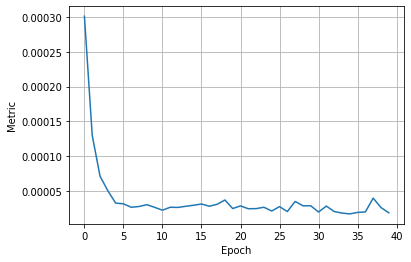

END OF EPOCH 39


In [26]:
#!g1.1

# TRAIN
history = defaultdict(list)
for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, TaskConfig.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, TaskConfig.device, wandb=wandb)
    history['val_metric'].append(au_fa_fr)

    torch.save({
        'model_state_dict': model.state_dict(),
    }, f'base_model_{n}.pth')
    
    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [399]:
#!g1.1
validation(
    model, val_loader,
    melspec_val, TaskConfig.device
)

102it [00:00, 105.80it/s]


1.8851482808763522e-05

In [ ]:
#!g1.1


In [ ]:
#!g1.1


In [47]:
#!g1.1
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

print("sepconv prarams", count_parameters(model.conv))
print("gru prarams", count_parameters(model.gru))
print("attn prarams", count_parameters(model.attention))
print("Head prarams", count_parameters(model.classifier))

sepconv prarams 808
gru prarams 65280
attn prarams 4225
Head prarams 130


In [397]:
#!g1.1
model = model.cuda()
model.load_state_dict(torch.load("base_model_39.pth")['model_state_dict'])

<All keys matched successfully>

In [266]:
#!g1.1


# Streaming

In [523]:
sample.shape

torch.Size([1, 40, 1010])

In [524]:
#!g1.1

samples = []
labels = []

for i in range(12485, 12495):
    sample = val_set[i]
    #print(sample['keywors'])
  #  print(sample['utt'].shape)
    sample, label = Collator()([sample])
    labels.append(label.item())
    sample = melspec_val(sample.to(TaskConfig.device))
    
    samples.append(sample)
    
sample = torch.cat(samples, dim=-1)
labels

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [525]:
#!g1.1

class KWSDecoder:
    def __init__(self, model, config, window_size=60):
        self.model = model
        self.window_size = window_size

        self.receptive_field = config.kernel_size[1]

        self.reset()
    
    def reset(self):
        self.buffer = None
        self.attn_buffer = []
        self.gru_outputs = []
        self.probas = torch.zeros((1,)).to(TaskConfig.device)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return torch.zeros(TaskConfig.gru_num_layers, 1, TaskConfig.hidden_size).to(TaskConfig.device)
         
        input = input.unsqueeze(dim=1)
        # batch_size, n_channels, mels, len
        
        conv_output = self.conv(input).transpose(-1, -2)
        # batch_size, len, hidden
        
        gru_output, _ = self.gru(conv_output)
        # batch_size, len, hidden
        
        contex_vector = self.attention(gru_output)
        # batch_size, hidden
        
        output = self.classifier(contex_vector)
        # batch_size, proba
        
        return output

    @torch.no_grad()
    def decode(self, x):
        x = x.unsqueeze(dim=1)
        
        if self.buffer is None:
            self.buffer = x
        else:
            self.buffer = torch.cat((self.buffer, x), dim=-1)
            
        if self.buffer.shape[-1] < self.receptive_field:
            return
            
        self.buffer = self.buffer[:, :, :, -self.receptive_field:]
        print("buffer", self.buffer.shape)
                    
        output = self.model.conv(self.buffer).transpose(-1, -2)
        print("conv output", output.shape)
        
        output, hidden = self.model.gru(output, self.hidden)
        # output (1, 1, hidden_size)
        self.hidden = hidden
        print("gru out", output.shape)
        
        self.gru_outputs.append(output)
        
        if len(self.gru_outputs) > self.window_size:
            self.gru_outputs = self.gru_outputs[1:]
        
        output = torch.cat(self.gru_outputs, dim=1)
        
        print("attn input", output.shape)
        
        contex_vector = self.model.attention(output)
        print("attn out", contex_vector.shape)
        
        proba = self.model.classifier(contex_vector)
        print("proba", proba.shape)
        proba = F.softmax(proba)[0][1]
        
        self.probas = torch.cat((self.probas, proba.unsqueeze(0)))



In [526]:
#!g1.1
memory_size = 11
decoder = KWSDecoder(model, config, window_size=memory_size)

In [527]:
#!g1.1
step = config.stride[1]

for i in range(0, sample.shape[2], step):
    decoder.decode(sample[:, :, i:i+step])

buffer torch.Size([1, 1, 40, 20])
conv output torch.Size([1, 1, 144])
gru out torch.Size([1, 1, 64])
attn input torch.Size([1, 1, 64])
attn out torch.Size([1, 64])
proba torch.Size([1, 2])
buffer torch.Size([1, 1, 40, 20])
conv output torch.Size([1, 1, 144])
gru out torch.Size([1, 1, 64])
attn input torch.Size([1, 2, 64])
attn out torch.Size([1, 64])
proba torch.Size([1, 2])
buffer torch.Size([1, 1, 40, 20])
conv output torch.Size([1, 1, 144])
gru out torch.Size([1, 1, 64])
attn input torch.Size([1, 3, 64])
attn out torch.Size([1, 64])
proba torch.Size([1, 2])
buffer torch.Size([1, 1, 40, 20])
conv output torch.Size([1, 1, 144])
gru out torch.Size([1, 1, 64])
attn input torch.Size([1, 4, 64])
attn out torch.Size([1, 64])
proba torch.Size([1, 2])
buffer torch.Size([1, 1, 40, 20])
conv output torch.Size([1, 1, 144])
gru out torch.Size([1, 1, 64])
attn input torch.Size([1, 5, 64])
attn out torch.Size([1, 64])
proba torch.Size([1, 2])
buffer torch.Size([1, 1, 40, 20])
conv output torch.Siz

In [528]:
#!g1.1
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


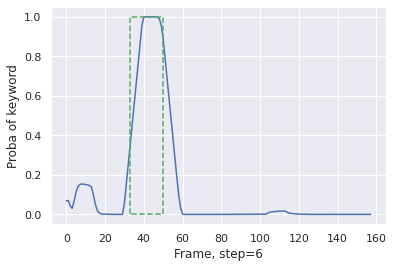

In [546]:
#!g1.1
import seaborn as sns
sns.set()

window_size = 10
left_x = (labels.index(1) * 101) // step 
right_x = (labels.index(1) + 1) * 101 // step

fig, ax = plt.subplots()

ax.plot(
    np.arange(decoder.probas.shape[0] - window_size + 1),
    moving_average(decoder.probas.cpu().numpy(), window_size)
)

ax.plot(
    [left_x, left_x, right_x, right_x, left_x],
    [0,1,1,0,0],
    c='g',
    linestyle='dashed'
)

ax.set(
    xlabel=f'Frame, step={step}',
    ylabel='Proba of keyword'
);

In [ ]:
#!g1.1


# Compresing

In [66]:
#!g1.1
import time
from thop import profile, clever_format, rnn_hooks


def get_size_in_megabytes(model):
    num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
    param_size = next(model.parameters()).element_size()
    return (num_params * param_size) / (2 ** 20)


class Timer:
    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t:.2f}")


## Базовый сценарий

In [485]:
#!g1.1

# берем один бач и гоняем на нем, тк датасфера на даталоадерах постоянно непредсказуемо подвисает
inference_device = 'cpu'

melspec_inf = LogMelspec(is_train=False, config=TaskConfig)
melspec_inf.melspec.to(inference_device)

batch, labels = next(iter(val_loader))
batch, labels = batch.to(inference_device), labels.to(inference_device)
batch = melspec_inf(batch)

In [60]:
#!g1.1

# base model
def get_base_model():
    config = TaskConfig()
    model = CRNN(config).to(config.device)
    model.load_state_dict(torch.load("base_model_39.pth")['model_state_dict'])
    
    return model

base_model = model

In [482]:
#!g1.1
def report_model(model, batch, device, model_name="Base", n_batches=1000, wandb=None):
    model = model.to(device)
    batch = batch.to(device)
    print(f"Profile Model {model_name}")
    macs_number, params_number = profile(model, (batch, )) 
    macs, params = clever_format([macs_number, params_number], "%3f")
    print(f"Macs - {macs}, params - {params}")

    model_size = get_size_in_megabytes(model)
    print(f"Model size - {model_size} Mb")
                
    au_fa_fr = validation(model, val_loader,
                          melspec_inf, inference_device)
    print("AU_FA_FR", au_fa_fr)
    
    if wandb is not None:
        wandb.log({
            "val_au_fa_fr": au_fa_fr,
            "Macs": macs_number,
            "Params": params_number,
            "size": model_size
        })
            

In [72]:
#!g1.1
report_model(base_model, batch, inference_device, wandb=wandb)

Profile Model Base
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
Macs - 119.527424M, params - 70.443000K
Model size - 0.2687187194824219 Mb
Batch time | Elapsed time : 1.19


102it [00:02, 39.62it/s]


AU_FA_FR 1.8851482808763522e-05


In [357]:
#!g1.1


## Дистиляция

In [449]:
#!g1.1

def train_model(distil_model, opt, config, model, name=None, wandb=None):
    if name is None:
        name = ''
        
    history = defaultdict(list)

    for n in range(config.num_epochs):
        train_epoch(
            distil_model, opt, train_loader,
            melspec_train, config.device,
            distil=(
                model.to(config.device),
                config.distil_alpha,
                KDLoss(5, config.distil_alpha, reduction='mean')
            )
        )

        torch.save({
            'model_state_dict': distil_model.state_dict(),
        }, f'models/distil_model_{name}_{n}.pth')
        
        if n % config.val_every_epoch == 0:
            au_fa_fr = validation(distil_model, val_loader,
                                  melspec_val, config.device, wandb=wandb)
            history['val_metric'].append(au_fa_fr)

            clear_output()
            plt.plot(history['val_metric'])
            plt.ylabel('Metric')
            plt.xlabel('Epoch')
            plt.grid()
            plt.show()

            print('END OF EPOCH', n)

def train(config, name=None):
    distil_model = CRNN(config).to(config.device)

  #  print(distil_model)

    opt = torch.optim.Adam(
        distil_model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    
    wandb.init(
        project='kws',
        name=name,
        config=config.__dict__
    )
    
    train_model(distil_model, opt, config, model, wandb=wandb, name=name)
    
    return distil_model, wandb

In [450]:
@dataclasses.dataclass
class DistilTaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 1e-4
    weight_decay: float = 0
    num_epochs: int = 100
    n_mels: int = 40
    cnn_out_channels: int = 6
    kernel_size: Tuple[int, int] = (5, 25)
    stride: Tuple[int, int] = (2, 12)
    hidden_size: int = 20
    gru_num_layers: int = 1
    bidirectional: bool = False
    num_classes: int = 2
    val_every_epoch: int = 3
    sample_rate: int = 16000
    distil_alpha = 0.9
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu'
    )

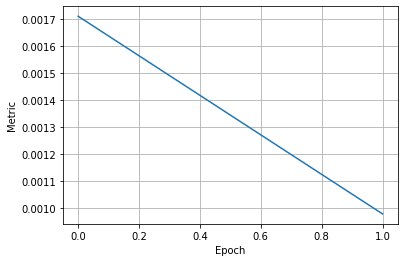

END OF EPOCH 3


208it [00:05, 36.16it/s]
Exception in thread Thread-3456:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/opt/conda/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/opt/conda/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/opt/conda/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=

KeyboardInterrupt: 

In [469]:
n_exp = 0
skip_exps = 1

for cnn_channel in [2, 3, 4]:
    for kernel in [20, 25]:
        for hidden in [12, 16, 20]:
            for stride in [6]:
                n_exp += 1
                
                if n_exp <= skip_exps:
                    continue
                    
                config = DistilTaskConfig(
                    cnn_out_channels=cnn_channel,
                    kernel_size=(5, kernel),
                    hidden_size=hidden,
                    stride=(2, stride)
                )

                distil_model, wandb = train(config, f"chan={cnn_channel}, kernel={kernel}, hidden={hidden}, stride={stride}")

                report_model(distil_model, batch, inference_device, wandb=wandb)

In [390]:
#!g1.1
distil_model.load_state_dict(torch.load("best_distil_20_2_12.pth")['model_state_dict'])

<All keys matched successfully>

In [459]:
report_model(model, batch, inference_device)

Profile Model Base
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
Macs - 119.527424M, params - 70.443000K
Model size - 0.2687187194824219 Mb
Batch time | Elapsed time : 1.19


102it [00:00, 102.30it/s]


AU_FA_FR 1.8851482808763522e-05


In [502]:
distil_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 2, kernel_size=(5, 20), stride=(2, 6))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(36, 16, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)

In [503]:
torch.save({
    'model_state_dict': distil_model.state_dict(),
}, f'models/best_distil_model.pth')

In [501]:
#!g1.1
report_model(distil_model, batch, inference_device)

Profile Model Base
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
Macs - 11.852800M, params - 3.117000K
Model size - 0.011890411376953125 Mb


102it [00:04, 23.31it/s]


AU_FA_FR 3.590076624802828e-05


In [473]:
0.2687187 / 0.0118

22.772771186440675

In [472]:
119.52 / 11.852

10.084373945325682

## Квантизация

In [493]:
import torch.quantization

quantizated_model = torch.quantization.quantize_dynamic(distil_model.cpu())

quantizated_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 2, kernel_size=(5, 20), stride=(2, 6))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): DynamicQuantizedGRU(36, 16, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=16, out_features=16, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=16, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
  )
  (classifier): DynamicQuantizedLinear(in_features=16, out_features=2, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [494]:
quantizated_model = quantizated_model.cpu()

Будем считать Macs таким же как и обычной модели, памяти посчитаем по чекпоинту

In [490]:
validation(
    quantizated_model, val_loader,
    melspec_inf, 'cpu'
)

102it [00:02, 34.45it/s]


3.9493229891863565e-05

In [509]:
get_size_in_megabytes(quantizated_model)

0.00077056884765625

In [558]:
quantizated_model.state_dict()['attention.energy.0._packed_params._packed_params'][0].shape

torch.Size([16, 16])

In [551]:
quantizated_model.attention.energy[0].weight()

tensor([[ 0.0485, -0.5554,  0.1190, -0.0573,  0.0485, -0.2204, -0.3394,  0.0970,
         -0.0220,  0.0044, -0.1807,  0.1895,  0.0926,  0.1014,  0.5554, -0.0485],
        [ 0.4143, -0.5554,  0.3482, -0.1895, -0.1234,  0.1499,  0.0573, -0.0793,
         -0.1719, -0.1411,  0.0176,  0.2997,  0.3835,  0.1014,  0.4628, -0.1411],
        [ 0.3394, -0.1587,  0.2380, -0.4452, -0.1851,  0.1278, -0.2821,  0.0573,
         -0.1851,  0.1058, -0.0485, -0.0705,  0.1675, -0.3438, -0.3526,  0.1058],
        [ 0.1190,  0.2777, -0.1587,  0.4276,  0.1719, -0.1675, -0.1455,  0.1543,
          0.1763,  0.0617, -0.1763,  0.0926, -0.5245, -0.0749, -0.4188,  0.1807],
        [ 0.0264,  0.4320, -0.3350,  0.1807, -0.1411,  0.1234,  0.1895, -0.2689,
          0.1631, -0.0353,  0.0000, -0.0441, -0.0353, -0.0882, -0.3659,  0.2468],
        [ 0.4628,  0.0088,  0.2072, -0.4099, -0.4276,  0.2645, -0.2821,  0.2292,
          0.0132,  0.2953, -0.2160, -0.2821, -0.0926,  0.0264, -0.4849,  0.5598],
        [-0.1366,  0.2

### Мерим память по честному

In [520]:
import os

def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size


In [533]:
model_size = print_size_of_model(model)

model:    	 Size (KB): 288.87


In [552]:
distil_model_size = print_size_of_model(distil_model)

model:    	 Size (KB): 19.549


In [553]:
quant_model_size = print_size_of_model(quantizated_model)

model:    	 Size (KB): 13.579


In [566]:
print_size_of_model(quantizated_model.attention.energy[0])

model:    	 Size (KB): 2.015


2015

In [537]:
model_size / distil_model_size, model_size / quant_model_size

(14.776714921479359, 21.273289638412255)